In [27]:
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_local_periodic_kernel(
    periodic_length_scale, period, amplitude, local_length_scale
):
    """
    Composite kernel functions which is product of ExpSinSquared and Exponential Quadratic
    """
    periodic = tfp.math.psd_kernels.ExpSinSquared(
        amplitude=amplitude, length_scale=periodic_length_scale, period=period
    )
    local = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=local_length_scale)
    return periodic * local

In [3]:
def get_cov_mat(
    x, periodic_length_scale=1.0, period=1.0, amplitude=1.0, local_length_scale=1.0
):
    cov = (
        get_local_periodic_kernel(
            periodic_length_scale=periodic_length_scale,
            period=period,
            amplitude=amplitude,
            local_length_scale=local_length_scale,
        )
        .matrix(x, x)
        .numpy()
    )
    return cov


In [4]:
xlim = (-3, 3)
seq_len = 100
x = np.expand_dims(np.linspace(*xlim, seq_len), 1)
n_clients = 1

In [5]:
cov = get_cov_mat(x)

2024-10-10 10:47:19.000515: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 10:47:19.003940: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 10:47:19.015585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 10:47:19.038128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 10:47:19.044214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 10:47:19.059237: I tensorflow/core/platform/cpu_feature_gu

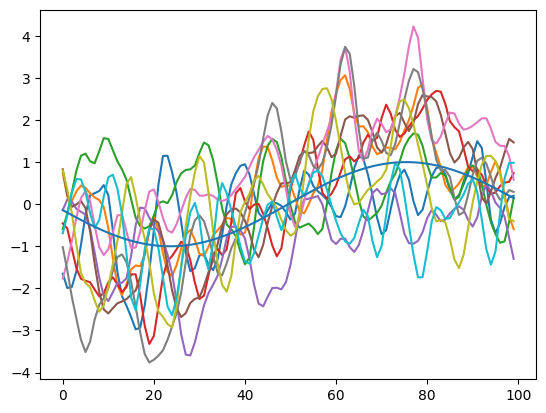

In [16]:
mean_seq = np.sin(x)
for _ in range(10):
    plt.plot(np.random.multivariate_normal(mean=np.squeeze(mean_seq), cov=cov, size=n_clients)[0])
plt.plot(np.squeeze(mean_seq))

/tmp/ipykernel_423462/2733292659.py:1: RuntimeWarning: invalid value encountered in log
  mean_seq = np.log(x)


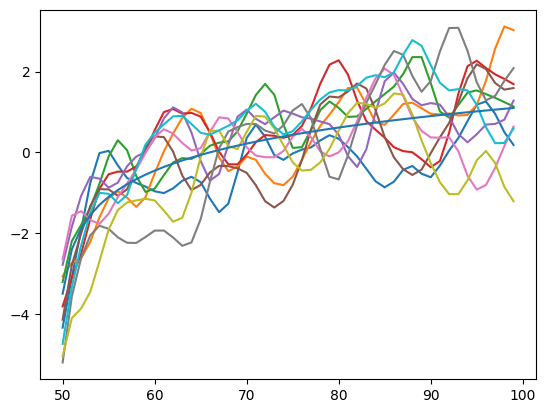

In [18]:
mean_seq = np.log(x)
for _ in range(10):
    plt.plot(np.random.multivariate_normal(mean=np.squeeze(mean_seq), cov=cov, size=n_clients)[0])
plt.plot(np.squeeze(mean_seq))

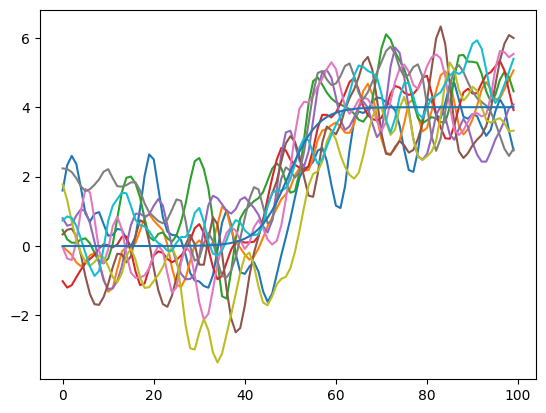

In [35]:
mean_seq = 4/(1 + np.exp(-5*x))
for _ in range(10):
    plt.plot(np.random.multivariate_normal(mean=np.squeeze(mean_seq), cov=cov, size=n_clients)[0])
plt.plot(np.squeeze(mean_seq))

In [36]:
n_clients = 7
y = np.random.multivariate_normal(mean=np.squeeze(mean_seq), cov=cov, size=n_clients)
thresh = np.quantile(y, [1 - 0.25], method="higher", axis=1).T
y_bin = (y >= thresh).astype(np.int8)

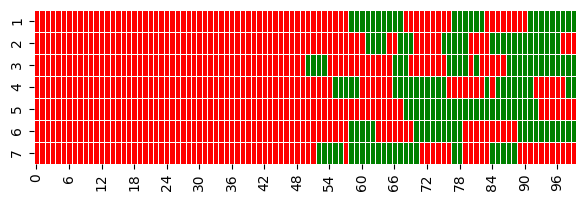

In [37]:
from  matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

countries = [i+1 for i in range(n_clients)]
formatted_array = list(range(seq_len))

availability_matrix = pd.DataFrame(y_bin, index = countries, columns = formatted_array)

plt.figure(figsize=(7, 2))
ax = plt.subplot()

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
sns.heatmap(availability_matrix.astype(int), annot=False, fmt='d', cbar=False, cmap=cmap, linewidths=0.5, linecolor='white', ax=ax) # create heatmap

if not isinstance(availability_matrix.columns[0], np.int64):
    plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
xticks = ax.get_xticks()
xticks = xticks[::2]
ax.set_xticks(xticks) # set new xticks